In [1]:
cd ~/Desktop/CS109/Data

/Users/Leah/Desktop/CS109/Data


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from numpy.random import randint
import seaborn as sns
from my_functions import import_gene_info
from my_functions import get_gene_name
from my_functions import get_gene_ID
from my_functions import for_loop_status
from my_functions import scale_predictor

In [3]:
# import data needed
GENE_INFO = import_gene_info()
df_full = pd.read_csv('gene_expression_unique.csv', index_col = 0)

# remove rows where DX is missing (there are 8, which are also missing many cog tests, so not worth imputing)
df_full = df_full[np.isfinite(df_full['DX'])]

# calculate change progression of disease, and rate of progression - using final, since first is same as DX for 430 patients
df_full['DX_Final_Progression'] = (df_full['Final_DX'] - df_full['DX']).apply(lambda x: 1 if x > 1 else x)
df_full['DX_Final_Rate'] = df_full['DX_Final_Progression']/df_full['Final_Delta_Time']

# standardize gene expression data
X_full = df_full.iloc[:,0:49386]
gene_cols = X_full.columns
length = len(gene_cols) - 1
index = 0
for gene in gene_cols:
    df_full = scale_predictor(df_full, gene)
    index = for_loop_status(length, index)

# drop columns and rows as appropriate
# drop MRI columns
df_no_MRIs = df_full.drop(df_full.columns[49435:49444], axis=1)
# drop baselines except for Years_bl, Months_bl, Month, M
df_no_bl = df_no_MRIs.drop(df_no_MRIs.columns[49436:49473], axis=1)
# drop FDG, PIB, AV45
df_no_PET = df_no_bl.drop(df_no_bl.columns[49408:49411], axis=1)
df_no_PET.to_csv('FINAL_GENE_EXPRESSION.csv')
# all cognitive test columns
cog_cols = df_no_PET.columns[49408:49432]
# find observations where cognitive test data is missing
missing_cog = df_no_PET.index[df_no_PET[cog_cols].isnull().any(axis=1)==True].tolist()
# drop rows where missing
df_no_missing_cog = df_no_PET.drop(missing_cog)
df_no_missing_cog.to_csv('DROPPED_GENE_EXPRESSION_UNIQUE.csv')

# split into train and test
np.random.seed(9001)
msk = np.random.rand(len(df_full)) < 0.5
df_train = df_full[msk]
df_test = df_full[~msk]

# split into X_train and X_test
X_train = df_train.iloc[:,0:49386]
X_test = df_test.iloc[:,0:49386]
y_train = df_train['Final_DX']
y_test = df_test['Final_DX']

# compute correlations of Final_DX with all genes
gene_corrs = []
gene_cols = X_train.columns
length = len(gene_cols) - 1
index = 0
for gene in gene_cols:
    gene_corrs.append(X_train[gene].corr(y_train))
    index = for_loop_status(length, index)

# store correlation data in dataframe
gene_corr_df = pd.DataFrame()
gene_corr_df['gene'] = gene_cols
gene_corr_df['corr'] = gene_corrs
gene_corr_df = gene_corr_df.sort_values('corr')

plt.hist(gene_corrs);
plt.xlabel('Correlation of Gene with Final Diagnosis')
plt.ylabel('Frequency')
plt.show()

99.356080%%

In [4]:
# get most highly correlated genes
n = 10
top_neg_corr = gene_corr_df.head(n)
top_pos_corr = gene_corr_df.tail(n)
top_corrs = pd.concat([top_pos_corr, top_neg_corr])
top_genes = top_corrs['gene'].values
gene_names = []
for gene in top_corrs.gene:
    gene_names.append(get_gene_name(gene, GENE_INFO))
top_corrs['name'] = gene_names
top_corrs

,gene,corr,name
3661,11718761_a_at,0.238848,WLS
19838,11734938_x_at,0.239888,CSF2RA
3247,11718347_a_at,0.242479,S100P
46737,11761837_at,0.242760,RALGPS1
26053,11741153_a_at,0.243592,NCF2
2546,11717646_a_at,0.257281,MCMBP
38089,11753189_a_at,0.260366,MBOAT1
29918,11745018_a_at,0.278448,WLS
3660,11718760_a_at,0.279349,WLS
18413,11733513_a_at,0.284054,WLS


In [5]:
# correlations for genes that are known to be related to Alzheimer's
print('TOMM40L', gene_corr_df.loc[gene_corr_df['gene'] == get_gene_ID('TOMM40L', GENE_INFO)]['corr'].values[0])
print('TOMM40', gene_corr_df.loc[gene_corr_df['gene'] == get_gene_ID('TOMM40', GENE_INFO)]['corr'].values[0])
print('APOE', gene_corr_df.loc[gene_corr_df['gene'] == get_gene_ID('APOE', GENE_INFO)]['corr'].values[0])

TOMM40L -0.0334655118838
TOMM40 -0.00314336161103
APOE -0.0143338526988


In [6]:
# Get X and y for training and testing for initial modeling
topcor_mod = {}
topcor_mod['Xtrain'] = X_train[top_genes].values
topcor_mod['Xtest'] = X_test[top_genes].values
topcor_mod['ytrain'] = y_train.values
topcor_mod['ytest'] = y_test.values

# try an initial simple logistic regression model
topcor_mod['logit_mn'] = LogisticRegressionCV(Cs=7, penalty='l2', random_state = 9001, multi_class='multinomial')
topcor_mod['logit_mn'].fit(topcor_mod['Xtrain'], topcor_mod['ytrain'])

topcor_mod['ypred_train'] = topcor_mod['logit_mn'].predict(topcor_mod['Xtrain'])
topcor_mod['ypred_test'] = topcor_mod['logit_mn'].predict(topcor_mod['Xtest'])

topcor_mod['yrand_train'] = randint(3, size = len(X_train))
topcor_mod['yrand_test'] = randint(3, size = len(X_test))

print('Logistic multinomial class. accuracy, train: ', accuracy_score(topcor_mod['ytrain'], topcor_mod['ypred_train']))
print('Logistic multinomial class. accuracy, test: ', accuracy_score(topcor_mod['ytest'], topcor_mod['ypred_test']))

print('Random class. accuracy, train: ', accuracy_score(topcor_mod['ytrain'], topcor_mod['yrand_train']))
print('Random class. accuracy, test: ', accuracy_score(topcor_mod['ytest'], topcor_mod['yrand_test']))

Logistic multinomial class. accuracy, train:  0.647887323944
Logistic multinomial class. accuracy, test:  0.359649122807
Random class. accuracy, train:  0.291079812207
Random class. accuracy, test:  0.350877192982


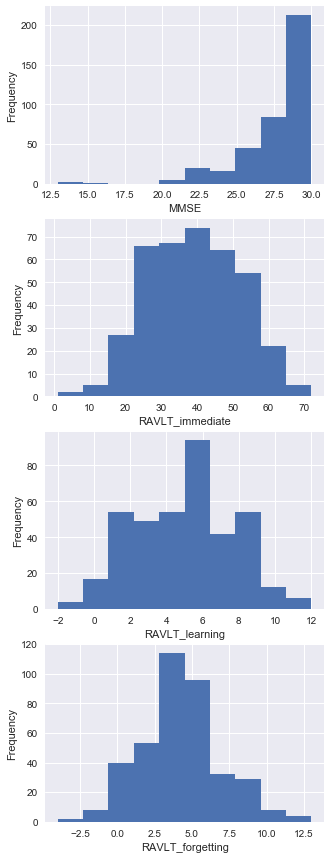

In [7]:
df = df_no_missing_cog

cog_cols1 = df.columns[49411:49415]
fig, ax = plt.subplots(len(cog_cols1), 1, figsize=(5, 15))
for i in range(len(cog_cols1)):
    ax[i].hist(df[cog_cols1[i]])
    ax[i].set_xlabel(cog_cols1[i])
    ax[i].set_ylabel("Frequency")

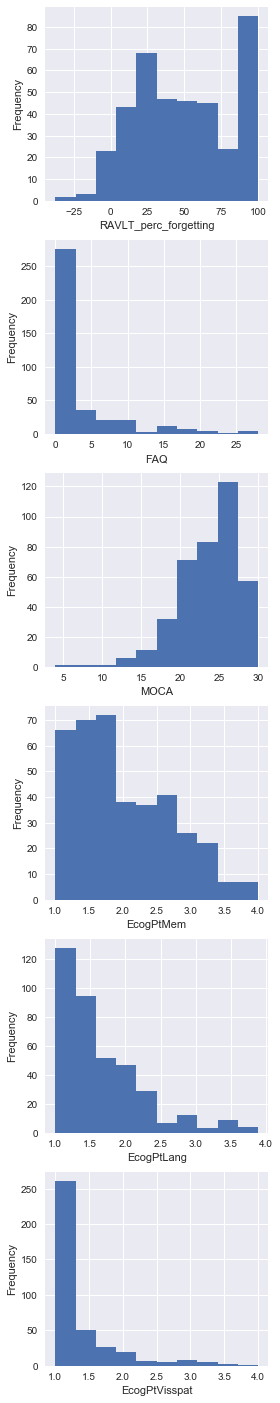

In [8]:
cog_cols2 = df.columns[49415:49421]
fig, ax = plt.subplots(len(cog_cols2), 1, figsize=(4, 25))
for i in range(len(cog_cols2)):
    ax[i].hist(df[cog_cols2[i]])
    ax[i].set_xlabel(cog_cols2[i])
    ax[i].set_ylabel("Frequency")

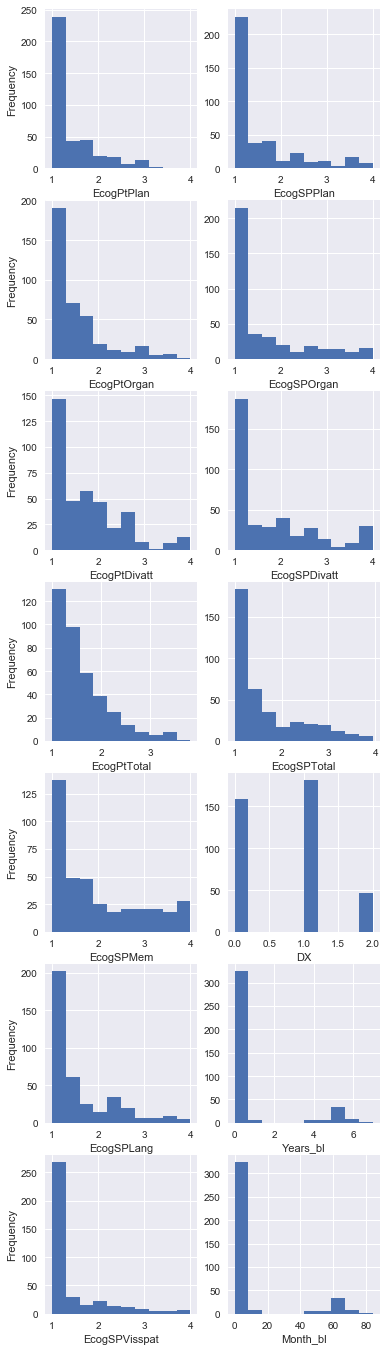

In [9]:
EcogPt_cols = df.columns[49421:49428]
fig, ax = plt.subplots(len(EcogPt_cols), 2, figsize=(6, 24))
for i in range(len(EcogPt_cols)):
    ax[i][0].hist(df[EcogPt_cols[i]])
    ax[i][0].set_xlabel(EcogPt_cols[i])
    ax[i][0].set_ylabel("Frequency")
EcogSP_cols = df.columns[49428:49435]
for i in range(len(EcogSP_cols)):
    ax[i][1].hist(df[EcogSP_cols[i]])
    ax[i][1].set_xlabel(EcogSP_cols[i])

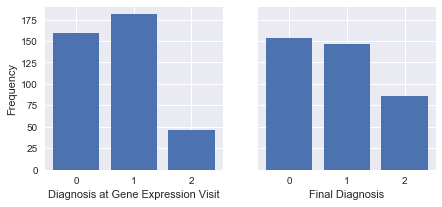

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(7,3), sharey=True)
dx_counts = df.groupby(['DX']).size()
ax[0].bar(dx_counts.index, dx_counts.values)
ax[0].set_xlabel('Diagnosis at Gene Expression Visit')
ax[0].set_ylabel("Frequency")
final_dx_counts = df.groupby(['Final_DX']).size()
ax[1].bar(final_dx_counts.index, final_dx_counts.values)
ax[1].set_xlabel('Final Diagnosis')

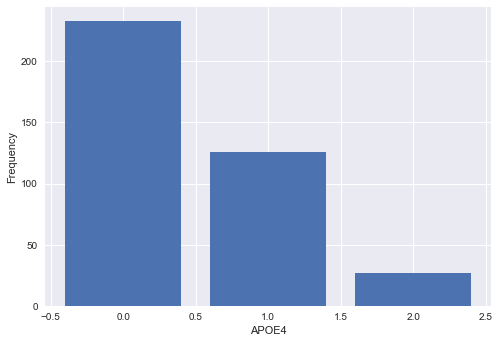

In [11]:
def plt_bar(col):
    counts = df.groupby([col]).size()
    plt.bar(counts.index, counts.values)
    plt.xlabel(col)
    plt.ylabel('Frequency')

# APOE4 from ADNIMERGE
plt_bar('APOE4')

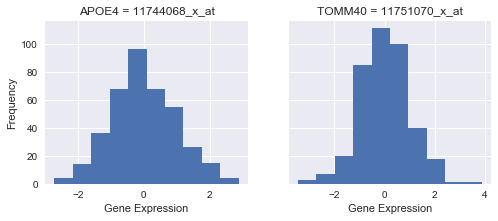

In [12]:
# plot APOE4 and TOMM40 gene expression
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True);
ax[0].hist(df['11744068_x_at']);
ax[0].set_title('APOE4 = 11744068_x_at');
ax[0].set_xlabel('Gene Expression');
ax[0].set_ylabel('Frequency');
ax[1].hist(df['11751070_x_at']);
ax[1].set_title('TOMM40 = 11751070_x_at');
ax[1].set_xlabel('Gene Expression');

In [13]:
# compiling correlation between cognitive tests
df_full = pd.read_csv('DROPPED_GENE_EXPRESSION_UNIQUE.csv', index_col = 0)
cog_cols = df_full.columns[49408:49432]
df_cog = df_full[cog_cols]
df_cog['Final_DX'] = df_full['Final_DX']
df_cog['DX'] = df_full['DX']
corr_matrix = np.corrcoef(df_cog, rowvar = False)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
print("Cognitive Test Correlations with Final_DX\n")
final_dx_df = pd.DataFrame()
final_dx_df['cog'] = df_cog.columns
final_dx_df['val'] = corr_matrix[24,:]
final_dx_df = final_dx_df.sort_values(['val'])
final_dx_df.head(20)

Cognitive Test Correlations with Final_DX



,cog,val
9,MOCA,-0.610607
3,MMSE,-0.581375
4,RAVLT_immediate,-0.549648
5,RAVLT_learning,-0.375219
6,RAVLT_forgetting,0.226330
15,EcogPtDivatt,0.295476
12,EcogPtVisspat,0.342990
14,EcogPtOrgan,0.348633
11,EcogPtLang,0.367308
13,EcogPtPlan,0.396204


In [15]:
print("Cognitive Test Correlations with DX\n")
dx_df = pd.DataFrame()
dx_df['cog'] = df_cog.columns
dx_df['val'] = corr_matrix[25,:]
dx_df = final_dx_df.sort_values(['val'])
dx_df.head(20)

Cognitive Test Correlations with DX



,cog,val
9,MOCA,-0.610607
3,MMSE,-0.581375
4,RAVLT_immediate,-0.549648
5,RAVLT_learning,-0.375219
6,RAVLT_forgetting,0.226330
15,EcogPtDivatt,0.295476
12,EcogPtVisspat,0.342990
14,EcogPtOrgan,0.348633
11,EcogPtLang,0.367308
13,EcogPtPlan,0.396204


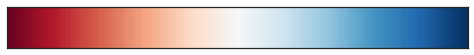

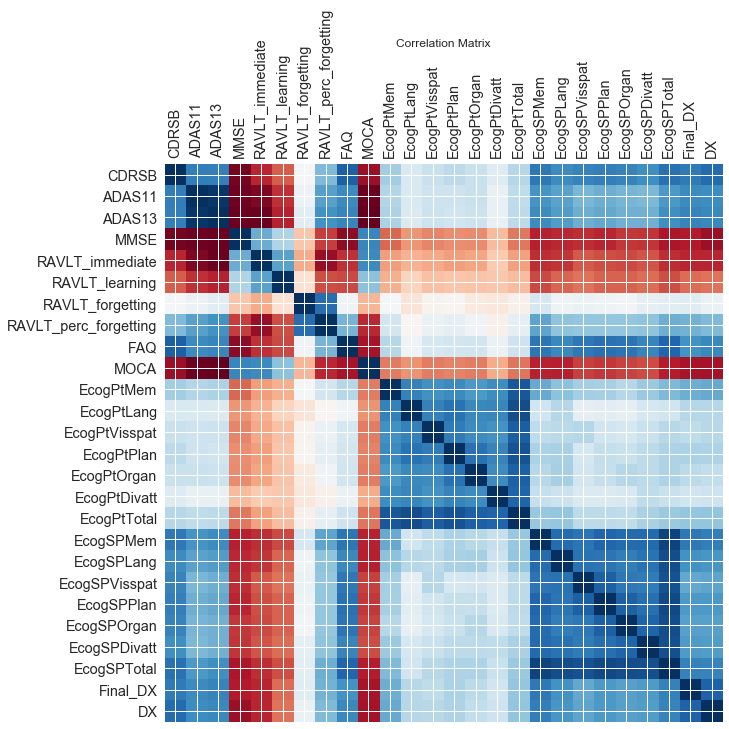

In [16]:
dpal = sns.choose_colorbrewer_palette('diverging', as_cmap=True)
plt.rcParams["figure.figsize"] = [10,10]
plt.matshow(corr_matrix, cmap=dpal)
ax = plt.gca()
ax.tick_params(axis='both', which='both',length=0);
plt.title("Correlation Matrix", y=1.2)
plt.xticks(range(26), df_cog.columns, rotation=90, fontsize = 'large')
plt.yticks(range(26), df_cog.columns, fontsize = 'large');